# Working Quantum Circuit Simulator with Parametric Gates

## Library Imports
- Numpy: Matrix operations
- Rantom: Weighted random
- Matplotlib: Graphing the probabilities of each outcome
- Sympy: Parsing and generating the parametric phrases for the parametric gate
- Math: exp()

In [65]:
import numpy as np
import random
import matplotlib as plt
import sympy as sp
from sympy import *
import math

## Getting the Ground State

The statevector of 𝑛 qubits is given by the Tensor Product (Kronecker Product) of the given qubit states. 
Since we are creating a statevector of the ground state, we can say that all qubits in the system are currently 
$\begin{bmatrix}1\\0\end{bmatrix}$.

In [66]:
#Creates the statevector with groundstate qubits by default
def get_ground_state(num_qubits):

    q0 = [1., 0.] #ground state
    # return vector of size 2**num_qubits with all zeroes except first element which is 1
    elements = q0
    for i in range(0, num_qubits-1):
        elements = np.kron(elements, q0)
    #elements = np.zeros(2**num_qubits)
    #elements[0]=1
    return elements

## Unitary Creation

I have predefined the gates that you can use in this program, but it's important to note that even though these single qubit gates can work on single qubits, we need a matrix operator to apply the qubit to the correct target qubit in a system that has $n>=2$ qubits. In a two qubit system where $U$ is a gate,
- To apply the gate to the first qubit: $U \otimes I$
- To apply the gate to the second qubit: $I \otimes U$


### Parametric Gate(s): U3 is Universal

$U3$ is the most general form of a single qubit unitary, defined by $$U(\theta, \phi, \lambda) = \begin{pmatrix}cos(\theta/2) & -e^{i\lambda}sin(\theta/2)\\e^{i\phi}sin(\theta/2) & e^{i\lambda+i\phi}cos(\theta/2)\end{pmatrix}$$

You can make certain input values to $U$ constant to create either $U2$, $U1$, or the rotation gates $RX, RY,$ and $RZ$ (See [Qiskit's Documentation](https://qiskit.org/documentation/tutorials/circuits/3_summary_of_quantum_operations.html) for more information).

In [67]:
def find_parametric_op(total_qubits, target_qubits, params):
    thetaQ, lambdaQ, phiQ, imag = symbols("thetaQ lambdaQ phiQ imag")
    
    #Rotation with 3 Euler Angles!
    U3 = np.array([

    ["cos(thetaQ/2)","-exp(imag * lambdaQ) * sin(thetaQ / 2)"],
    ["exp(imag * phiQ) * sin(thetaQ / 2)","exp(imag * lambdaQ + imag * phiQ) * cos(thetaQ / 2)"]
    ]).astype("<U60")
    
    for i in range(0, len(U3)):
        for j in range(0, len(U3[i])):
            U3[i][j]=complex(N(sympify(U3[i][j]).subs(params)))
    
    I = np.identity(2)
    
    #makes list of matrices!
    targets_li = np.linspace(I, I, total_qubits, dtype=np.complex)

    #ONCE YOU HAVE THE ARRAY OF IDENTITY MATRICES AND YOU SET THE CHOICE TO BE THE INDEX OF THE TARGET
    
    targets_li[target_qubits[0]]=U3    
    
    O = np.kron(targets_li[0], targets_li[1])

    for i in range(2, len(targets_li)):
        O = np.kron(O, targets_li[i])
    #print(O)
    return O

### Non-Parametric Quantum Gates

While $X$, $Y$, and $Z$ can be represented through the parametric unitary matrix $U(\theta, \phi, \lambda)$, I found it much easier to use efficiently in a non-parametric manner. 

The $CNOT$ gate is a special case, because it uses two projection operators - $P0x0 = \begin{bmatrix}1&0\\0&0\end{bmatrix}$ and $P1x1 = \begin{bmatrix}0&0\\0&1\end{bmatrix}$ - to create the $CNOT$ gate.

In total, my Quantum Circuit Simulator can currently use:
- X
- Y
- Z
- H
- S
- T
- CNOT

In [68]:
def find_operator(total_qubits, gate_choice, target_qubits, params):
    #mandate that target_qubits has an array input!
    
    #DEFINING ALL OF THE GATES IN FIND_OPERATOR
    
    #Define X (NOT) Gate
    X = np.array([
    [0, 1],
    [1, 0]
    ])
    
    #Define Y Gate
    Y = np.array([

    [0,0-1j],
    [0+1j,0]
    ])
    
    #Define Z Gate
    Z = np.array([

    [1,0],
    [0,-1]
    ])
    
    # Define H (Hadamard) gate:

    H = np.array([
        [1/np.sqrt(2), 1/np.sqrt(2)],
        [1/np.sqrt(2), -1/np.sqrt(2)]
    ])
    
    # Define projection operator |0><0|

    P0x0 = np.array([
    [1, 0],
    [0, 0]
    ])

    # Define projection operator |1><1|

    P1x1 = np.array([
    [0, 0],
    [0, 1]
    ])
    
    S = np.array([

    [1,0],
    [0, 0+1j]
    ])

    T = np.array([

    [1,0],
    [0, 0-1j]
    ])

    
    #2x2 identity
    I = np.identity(2)
    
    choice = np.identity(2)
    
    if(len(target_qubits)==1):
        #makes list of matrices!
        targets_li = np.linspace(I, I, total_qubits, dtype=complex)
        
        #chooses where the unitary operator goes in the list of matrices, which will help with the creation
        #of the overall matrix operator
        if(gate_choice=="x" or gate_choice == "X"):
            targets_li[target_qubits[0]]=X
        if(gate_choice=="y" or gate_choice == "Y"):
            targets_li[target_qubits[0]]=Y
        if(gate_choice=="z" or gate_choice == "Z"):
            targets_li[target_qubits[0]]=Z
        elif(gate_choice=="h" or gate_choice == "H"):
            targets_li[target_qubits[0]]=H
        elif(gate_choice=="s" or gate_choice == "S"):
            targets_li[target_qubits[0]]=S
        elif(gate_choice=="t" or gate_choice == "T"):
            targets_li[target_qubits[0]]=T
        
        #ONCE YOU HAVE THE ARRAY OF IDENTITY MATRICES AND YOU SET THE CHOICE TO BE THE INDEX OF THE TARGET
        
        O = np.kron(targets_li[0], targets_li[1])
        
        for i in range(2, len(targets_li)):
            O = np.kron(O, targets_li[i])
        #print(O)
        return O
    
    elif(len(target_qubits)>1):
    #use projection operators to create CNOT!
        cx1 = np.linspace(I, I, total_qubits) 
        cx1[target_qubits[0]]=P0x0
        cx2 = np.linspace(I, I, total_qubits) 
        cx2[target_qubits[0]]=P1x1
        cx2[target_qubits[1]] = X
         
        O1 = np.kron(cx1[0], cx1[1])
        O2 = np.kron(cx2[0], cx2[1])
        
        for i in range(2, total_qubits):
            O1 = np.kron(O1, cx1[i])
            O2 = np.kron(O2, cx2[i])
        O_CNOT = O1+O2
        #print(O_CNOT)
        return O_CNOT

## Running the circuit
### Applying the Unitaries to the Statevector
This function takes in the initial state or ground state, the circuit (with all of the gates to be applied in sequential order), and the total number of qubits in the given system (which can be derived by $log_2$len$($state_vector$)$). The function iterates through the circuit and passes in the necessary information.

In [69]:
#This function selects the operator creation function based on the length of the params array (if anything is in it, it will use
#find_parametric_op instead of find_operator), and then iterates through the circuit to apply the gates to the statevector

def run_program(initial_state, circuit, total_qubits):
    
    final_state = initial_state
    
    #use find_parametric_op instead if len(params)>0
    
    
    for i in range(0, len(circuit)):
        if(len(circuit[i]["params"])>0):
            final_state = np.dot(final_state, find_parametric_op(total_qubits, circuit[i]["target"], circuit[i]["params"]))
        else:
            final_state = np.dot(final_state, find_operator(total_qubits, circuit[i]["gate"], circuit[i]["target"], []))
            
    return final_state



### Measuring the Weighted Random for one shot
1. The function below takes in the final statevector and gleans a probability vector,
    1. Recall that for a given state $\left| \psi\right> = \alpha\left| 0\right> + \beta\left| 1\right>$, the probabilities of the result being $\left| 0\right>$ or $\left| 1\right>$ are $|\alpha|^2$ and $|\beta|^2$ respectively,
2. After creating the probability vector, it also creates a vector with the binary representations for the possible qubits,
3. The function finally generates a value based on the binary representation vector, with the weights given as the probability vector.

In [70]:
#Just a function that measures the probabilities based on the amplitudes of each state in the statevector

def measure_all(state_vector):
    # choose element from state_vector using weighted random and return it's index
    
    #For example, return 00 for decimal index 0, or 11 for decimal index 3
    #fill the remaining values with zero
    
    #make empty string array
    bin_index = ["" for x in range(len(state_vector))]
    probabilities = [abs(state_vector[x])**2 for x in range(len(state_vector))]
    #print(probabilities)

    
    
    for i in range(0, len(bin_index)):
        #print(format(i, '00' + str(num_qubits) + 'b'))
        bin_index[i] = str(format(i, '00' + str(num_qubits) + 'b'))
    
    #comb_array = np.array([bin_index, state_vector])

    choice = random.choices(bin_index, probabilities)[0]
    
    #print(choice)
    return choice

### Getting Empirical Probabilities for $n$ Shots

For a given number of shots, $n$, the `get_counts` method:
1. Initializes a dictionary to store the unique values returned by the `measure_all` method,
2. Calls the `measure_all` method $n$ times and saves the number of times each unique value appeared in the aforementioned dictionary, 
3. Returns the dictionary

In [71]:
#Calls measure_all num_shots number of times (ex. 1000) and returns the results numerically

def get_counts(state_vector, num_shots):
    
    bin_index = ["" for x in range(len(state_vector))]
    
    for i in range(0, len(bin_index)):
        #print(format(i, '00' + str(num_qubits) + 'b'))
        bin_index[i] = str(format(i, '00' + str(num_qubits) + 'b'))
    
    values = {}
    
    for i in range(0, len(bin_index)):
        values[bin_index[i]]=0
    
    #setting all values to zero in the values dictionary
    
    for i in range(0, num_shots):
        values[measure_all(state_vector)] +=1

    for i in range(0, len(bin_index)):
        if(values[bin_index[i]]==0):
            del(values[bin_index[i]])
    
    return values

### The Program's Structure
The program consists of:
1. A circuit that is defined at the beginning, 
2. The ground state statevector,
3. The `run_program` call, 
4. The printed dictionary,
5. A bar chart of all of the values and their probabilities.

{'01': 470, '10': 530}


Text(0, 0.5, '# of Readings when Measured')

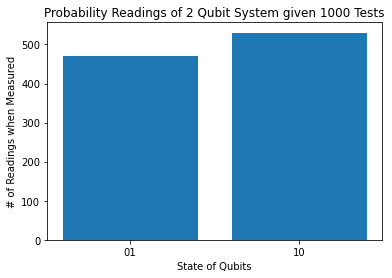

In [72]:
# Define program:

my_circuit = [
{ "gate": "h", "target": [0], "params": {} }, 
{ "gate": "cx", "target": [0, 1], "params": {} },
{ "gate": "u3", "target": [0], "params": { "thetaQ": np.pi, "phiQ": np.pi/2, "lambdaQ": -np.pi, "imag": 1j }}
]

num_qubits = 2

# Create "quantum computer" with 2 qubits (this is actually just a vector :) )

my_qpu = get_ground_state(num_qubits)

# Run circuit

final_state = run_program(my_qpu, my_circuit, num_qubits)

# Read results

num_shots = 1000

counts = get_counts(final_state, num_shots)

print(counts)

#Graphing the results as well

x_list = list(counts.keys())
#print(x_list)
height_list = list(counts.values())
#print(height_list)

plt.pyplot.bar(x=x_list, height=height_list)
plt.pyplot.title("Probability Readings of 2 Qubit System given " + str(num_shots)+ " Tests")
plt.pyplot.xlabel("State of Qubits")
plt.pyplot.ylabel("# of Readings when Measured")

# Thank you!
### I'm going to be adding support for VQAs soon!